✅ Loaded data — Shape: (518706, 100)
Truncated 'sub_grade' categories: 35 → 10
Truncated 'emp_title' categories: 109885 → 10
Truncated 'emp_length' categories: 12 → 10
Truncated 'url' categories: 398694 → 10
Truncated 'purpose' categories: 13 → 10
Truncated 'title' categories: 13 → 10
Truncated 'zip_code' categories: 907 → 10
Truncated 'addr_state' categories: 50 → 10
Truncated 'earliest_cr_line' categories: 683 → 10
Truncated 'int_rate_grade' categories: 14 → 10

🔍 Training Logistic Regression...


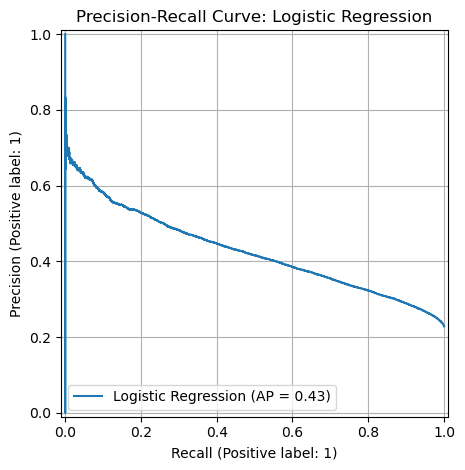


🔍 Training Random Forest...


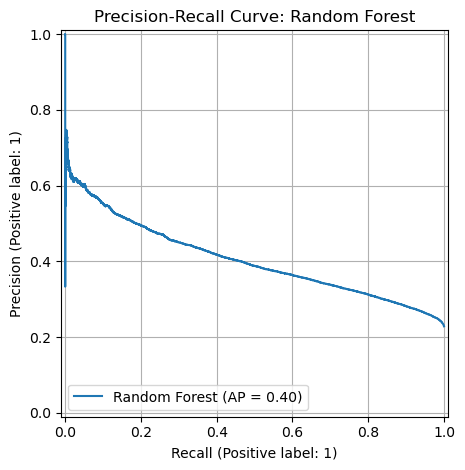


🔍 Training XGBoost...


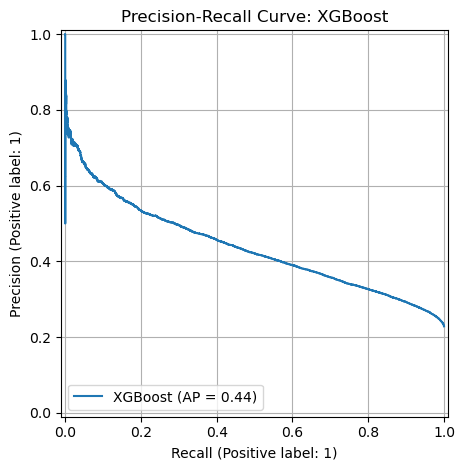


=== Logistic Regression ===
Optimal Threshold: 0.37
ROC AUC: 0.7220
F1 Score: 0.4472
Precision (on defaulters): 0.3009
Recall (on defaulters): 0.8704  ← critical in credit risk
Confusion Matrix:
Class 1 metrics:
Precision: 0.30
Recall: 0.87
F1: 0.45
[[30793 46086]
 [ 2955 19840]]

=== Random Forest ===
Optimal Threshold: 0.46
ROC AUC: 0.7047
F1 Score: 0.4503
Precision (on defaulters): 0.3139
Recall (on defaulters): 0.7960  ← critical in credit risk
Confusion Matrix:
Class 1 metrics:
Precision: 0.31
Recall: 0.80
F1: 0.45
[[37230 39649]
 [ 4651 18144]]

=== XGBoost ===
Optimal Threshold: 0.37
ROC AUC: 0.7275
F1 Score: 0.4499
Precision (on defaulters): 0.3034
Recall (on defaulters): 0.8701  ← critical in credit risk
Confusion Matrix:
Class 1 metrics:
Precision: 0.30
Recall: 0.87
F1: 0.45
[[31341 45538]
 [ 2960 19835]]

📉 Modeling results saved to: c:\Users\Alain\OneDrive\Desktop\Alain\Code Projects\borrowiq\data\model_outputs\modeling_results.json
💾 XGBoost pipeline saved to: c:\Users\Al

In [1]:
# ===========================
# 📦 LIBRARIES & DEPENDENCIES
# ===========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, precision_recall_curve,
    precision_score, recall_score, classification_report, PrecisionRecallDisplay
)
from sklearn.base import clone
import json
import warnings
from pathlib import Path
import joblib

warnings.filterwarnings("ignore")

# ===========================
# 🗓️ PATH MANAGEMENT
# ===========================

# Dynamically locate project root
root_dir = Path.cwd().parents[0] if "notebooks" in str(Path.cwd()) else Path(__file__).resolve().parents[1]
data_path = root_dir / "data" / "processed" / "borrowiq_final_model_ready.csv"
model_output_dir = root_dir / "data" / "model_outputs"
output_json_path = model_output_dir / "modeling_results.json"
model_output_dir.mkdir(parents=True, exist_ok=True)

# ===========================
# 📅 LOAD + STRATIFIED SAMPLE DATASET
# ===========================

assert data_path.exists(), f"❌ File not found: {data_path}"
df = pd.read_csv(data_path, low_memory=False)
print(f"✅ Loaded data — Shape: {df.shape}")

# Sanity filter
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
df = df[df['issue_d'] < pd.to_datetime('2018-07-01')]

# Stratified sample
sss = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=42)
for sample_idx, _ in sss.split(df, df['loan_status']):
    df_sampled = df.iloc[sample_idx].copy()

# ===========================
# 🎯 TARGET + SPLIT
# ===========================

X = df_sampled.drop(columns='loan_status')
y = df_sampled['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===========================
# 🧵 REDUCE CATEGORY CARDINALITY
# ===========================

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

TOP_K = 10
for col in cat_cols:
    orig_count = X_train[col].nunique()
    if orig_count > TOP_K:
        top_k = X_train[col].value_counts().nlargest(TOP_K).index
        X_train[col] = X_train[col].where(X_train[col].isin(top_k), 'Other')
        print(f"Truncated '{col}' categories: {orig_count} → {TOP_K}")
        X_test[col] = X_test[col].where(X_test[col].isin(top_k), 'Other')

# ===========================
# 🧼 PREPROCESSING PIPELINE
# ===========================

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# ===========================
# ⚙️ MODEL DEFINITIONS
# ===========================

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    "Logistic Regression": LogisticRegression(max_iter=300, class_weight='balanced', solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=6, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight,
                              tree_method='hist', max_depth=4, n_estimators=50)
}

# ===========================
# 🚀 TRAIN + EVALUATE
# ===========================

def cost_function(y_true, y_pred, fn_cost=5, fp_cost=1):
    assert set(np.unique(y_pred)).issubset({0, 1}), "y_pred must be binary (0 or 1)"
    cm = confusion_matrix(y_true, y_pred)
    return -(fn_cost * cm[1, 0] + fp_cost * cm[0, 1])

base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

results = {}
thresholds = np.linspace(0.1, 0.9, 10)

for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    pipeline = clone(base_pipeline)
    pipeline.steps[-1] = ('classifier', model)

    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    costs = []
    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        cost = cost_function(y_test, preds)
        costs.append(cost)

    best_idx = np.argmax(costs)
    best_thresh = thresholds[best_idx]
    y_pred = (y_proba >= best_thresh).astype(int)

    PrecisionRecallDisplay.from_predictions(y_test, y_proba, name=name)
    plt.title(f'Precision-Recall Curve: {name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    cost_score = cost_function(y_test, y_pred)

    results[name] = {
        "Best Threshold": float(best_thresh),
        "ROC AUC": float(roc_auc_score(y_test, y_proba)),
        "F1 Score": float(2 * (prec * rec) / (prec + rec + 1e-8)),
        "Precision": float(prec),
        "Recall": float(rec),
        "Cost Score": float(cost_score),
        "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist(),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True)
    }

    if name == "XGBoost":
        final_pipeline = pipeline
        final_proba = y_proba

# ===========================
# 📊 RESULTS SUMMARY
# ===========================

for model_name, metrics in results.items():
    print(f"\n=== {model_name} ===")
    print(f"Optimal Threshold: {metrics['Best Threshold']:.2f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"Precision (on defaulters): {metrics['Precision']:.4f}")
    print(f"Recall (on defaulters): {metrics['Recall']:.4f}  ← critical in credit risk")
    print("Confusion Matrix:")
    report = metrics['Classification Report']
    print("Class 1 metrics:")
    print(f"Precision: {report['1']['precision']:.2f}")
    print(f"Recall: {report['1']['recall']:.2f}")
    print(f"F1: {report['1']['f1-score']:.2f}")
    print(np.array(metrics['Confusion Matrix']))

# ===========================
# 📅 EXPORT RESULTS TO JSON
# ===========================

with open(output_json_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"\n📉 Modeling results saved to: {output_json_path}")

# ===========================
# 💾 SAVE FINAL ARTIFACTS
# ===========================

# Save XGBoost pipeline
pipeline_path = model_output_dir / "xgb_pipeline_model.pkl"
joblib.dump(final_pipeline, pipeline_path)
print(f"💾 XGBoost pipeline saved to: {pipeline_path}")

# Save transformed X_test
X_test_transformed = final_pipeline.named_steps['preprocessor'].transform(X_test)
X_test_transformed_df = pd.DataFrame(
    X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed
)
X_test_transformed_df.to_csv(model_output_dir / "X_test_transformed.csv", index=False)
print("📄 Transformed X_test saved to: X_test_transformed.csv")

# Save test labels
y_test.to_csv(model_output_dir / "y_test.csv", index=False)
print("📄 y_test saved to: y_test.csv")

# Save XGBoost probabilities
pd.DataFrame({'proba': final_proba}).to_csv(model_output_dir / "y_ensemble_proba.csv", index=False)
print("📄 y_ensemble_proba saved to: y_ensemble_proba.csv")


> ⚠️ **Note:** This notebook uses a 50,000-row sample by default for faster runs and easier sharing.  
> To use the full dataset, simply uncomment the full-load line and comment out the `.sample()` line.


## 📊 Model Comparison Visualization
This chart compares each model's F1 Score, ROC AUC, and annotated threshold. Helps visually interpret tradeoffs and strength.

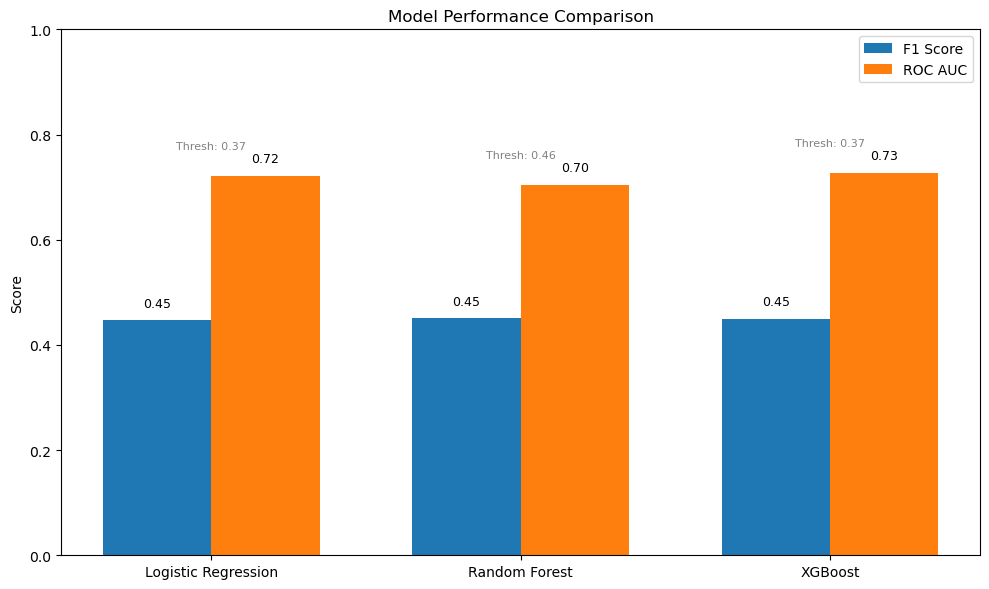

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Extract values from results dict
model_names = list(results.keys())
f1_scores = [results[m]["F1 Score"] for m in model_names]
roc_aucs = [results[m]["ROC AUC"] for m in model_names]
thresholds = [results[m]["Best Threshold"] for m in model_names]

# Plot F1 and ROC AUC scores
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(model_names))

plt.bar(x - bar_width / 2, f1_scores, width=bar_width, label='F1 Score')
plt.bar(x + bar_width / 2, roc_aucs, width=bar_width, label='ROC AUC')
plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()

# Annotate thresholds
for i, (f1, auc, thresh) in enumerate(zip(f1_scores, roc_aucs, thresholds)):
    plt.text(i - bar_width / 2, f1 + 0.02, f"{f1:.2f}", ha='center', va='bottom', fontsize=9)
    plt.text(i + bar_width / 2, auc + 0.02, f"{auc:.2f}", ha='center', va='bottom', fontsize=9)
    plt.text(i, max(f1, auc) + 0.05, f"Thresh: {thresh:.2f}", ha='center', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

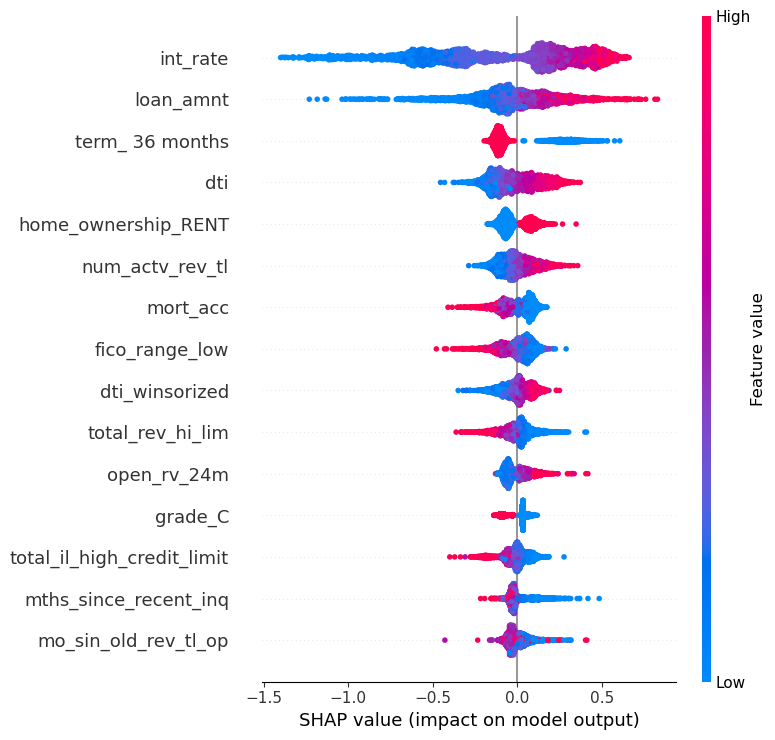

In [3]:
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd

# ✅ Fit the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=3))
])
xgb_pipeline.fit(X_train, y_train)

# ✅ Extract model and preprocessors
xgb_model = xgb_pipeline.named_steps['classifier']
fitted_preprocessor = xgb_pipeline.named_steps['preprocessor']

# ✅ Transform data (assumed to be dense)
X_train_transformed = fitted_preprocessor.transform(X_train)
X_test_transformed = fitted_preprocessor.transform(X_test)

# ✅ Recover feature names
ohe = fitted_preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

# ✅ Convert to DataFrame (dense)
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# ✅ Downsample to 3,000 rows
X_sample = X_train_df.sample(n=3000, random_state=42).copy()

# ✅ Sanitize column names
X_sample.columns = [col.replace('[', '')
                          .replace(']', '')
                          .replace('<', 'less_than')
                          .replace('>', 'greater_than') 
                    for col in X_sample.columns]

# ✅ Run SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

# ✅ SHAP summary plot
shap.summary_plot(shap_values, X_sample, max_display=15)





Finalize SHAP Outputs

In [ ]:
import shap
import pandas as pd
import numpy as np

# Get preprocessed test data with proper feature names
# Use the one-hot encoder’s get_feature_names_out for accurate column labels
preprocessor = xgb_pipeline.named_steps['preprocessor']
X_preprocessed = preprocessor.transform(X_test)

# Recover feature names from ColumnTransformer
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Feature names post-transformation
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_features])

# Wrap into DataFrame so SHAP plots work properly
X_preprocessed_df = pd.DataFrame(X_preprocessed.toarray() if hasattr(X_preprocessed, 'toarray') else X_preprocessed,
                                 columns=all_feature_names)

# Extract trained XGBoost model
xgb_model = xgb_pipeline.named_steps['classifier']

# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_preprocessed_df)
shap_values = explainer(X_preprocessed_df)

# Plot summary
shap.summary_plot(shap_values, X_preprocessed_df)

# Plot dependence for top feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_feature = all_feature_names[np.argmax(mean_abs_shap)]
shap.dependence_plot(top_feature, shap_values.values, X_preprocessed_df, feature_names=all_feature_names)



 51%|==========          | 51136/99674 [05:36<05:18]       

📏 Model Calibration Check

🔍 Training Logistic Regression...

🔍 Training Random Forest...

🔍 Training XGBoost...


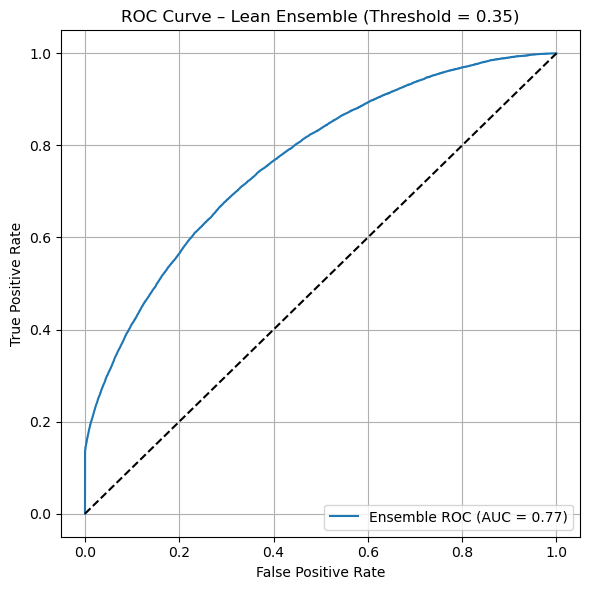

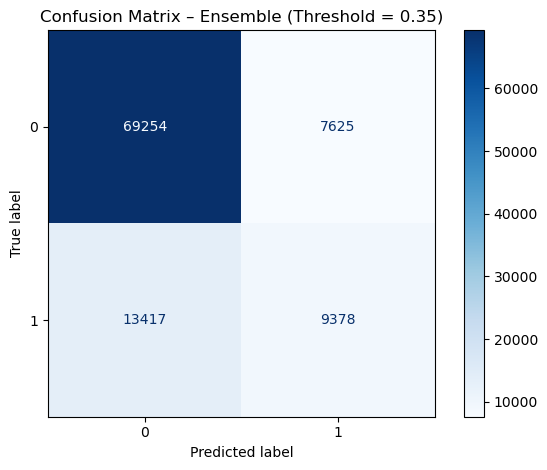


🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     76879
           1       0.55      0.41      0.47     22795

    accuracy                           0.79     99674
   macro avg       0.69      0.66      0.67     99674
weighted avg       0.77      0.79      0.78     99674



In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# ⚙️ 1. Define Base Models
lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                    use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)

# 🔁 2. Calibrate Models (Sigmoid = Fast)
cal_lr = CalibratedClassifierCV(lr, method='sigmoid', cv=3)
cal_rf = CalibratedClassifierCV(rf, method='sigmoid', cv=3)
cal_xgb = CalibratedClassifierCV(xgb, method='sigmoid', cv=3)

print("🔍 Training Logistic Regression...")
cal_lr.fit(X_train_transformed, y_train)

print("\n🔍 Training Random Forest...")
cal_rf.fit(X_train_transformed, y_train)

print("\n🔍 Training XGBoost...")
cal_xgb.fit(X_train_transformed, y_train)

# 🔮 3. Predict Probabilities and Average
proba_lr = cal_lr.predict_proba(X_test_transformed)[:, 1]
proba_rf = cal_rf.predict_proba(X_test_transformed)[:, 1]
proba_xgb = cal_xgb.predict_proba(X_test_transformed)[:, 1]

y_ensemble_proba = (proba_lr + proba_rf + proba_xgb) / 3

# 🔧 4. Apply Custom Threshold
threshold = 0.35
y_ensemble_pred = (y_ensemble_proba >= threshold).astype(int)

# 📈 5. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_ensemble_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve – Lean Ensemble (Threshold = {threshold})')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 6. Confusion Matrix & Classification Report
cm = confusion_matrix(y_test, y_ensemble_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix – Ensemble (Threshold = {threshold})')
plt.tight_layout()
plt.show()

print("\n🧾 Classification Report:")
print(classification_report(y_test, y_ensemble_pred))








🧮 Threshold Optimization + Risk Banding

🔍 Best Threshold for F1: 0.25


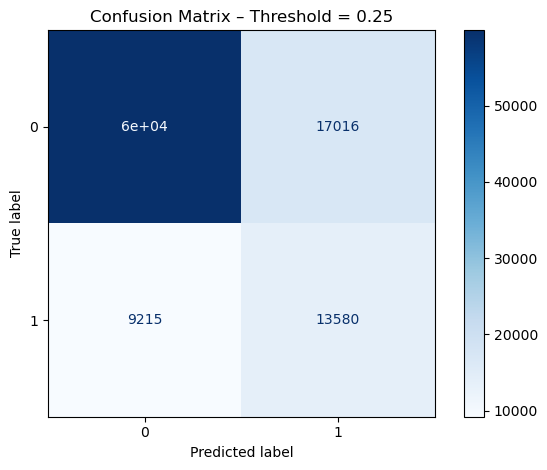

F1 Score @ 0.25: 0.5087

Risk Band Distribution:
Very Low     57856
Low          29162
Medium        8156
High          1468
Very High     3032
Name: count, dtype: int64

Default Rate by Risk Band:
           count  default_rate
band                          
Very Low   57856         0.114
Low        29162         0.290
Medium      8156         0.464
High        1468         0.638
Very High   3032         1.000


In [ ]:
# ================================
# 🎯 Threshold Optimization + Risk Banding 📊
# ================================

from sklearn.metrics import f1_score

# 🔍 Step 1: Find the threshold that maximizes F1
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, (y_ensemble_proba >= t).astype(int)) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"🔍 Best Threshold for F1: {best_threshold:.2f}")

# 🔐 Step 2: Predict with optimal threshold
y_opt_pred = (y_ensemble_proba >= best_threshold).astype(int)

# 📊 Step 3: Confusion Matrix
cm = confusion_matrix(y_test, y_opt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix – Threshold = {best_threshold:.2f}')
plt.tight_layout()
plt.show()

# 📈 F1 Score
print(f"F1 Score @ {best_threshold:.2f}: {f1_score(y_test, y_opt_pred):.4f}")

# 🧠 Step 4: Risk Banding
risk_band = pd.cut(
    y_ensemble_proba,
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

# 📉 Risk Band Distribution
band_counts = risk_band.value_counts().sort_index()
print("\nRisk Band Distribution:")
print(band_counts)

# 💥 Default Rate by Risk Band
risk_df = pd.DataFrame({'proba': y_ensemble_proba, 'actual': y_test, 'band': risk_band})
risk_summary = risk_df.groupby('band').agg(
    count=('actual', 'size'),
    default_rate=('actual', 'mean')
)

print("\nDefault Rate by Risk Band:")
print(risk_summary.round(3))


💾 Model Persistence

In [ ]:
from pathlib import Path
import joblib
import pandas as pd

# ==========================
# 💾 EXPORT MODEL & TEST DATA
# ==========================

# Define output directory using project-relative path
output_dir = Path("data/model_outputs")
output_dir.mkdir(parents=True, exist_ok=True)

# ✅ Save model to standardized location
model_path = output_dir / "xgb_pipeline_model.pkl"
joblib.dump(xgb_pipeline, model_path)

# ✅ Extract transformed feature names from ColumnTransformer
def get_feature_names_from_column_transformer(ct):
    feature_names = []
    for name, transformer, columns in ct.transformers_:
        if transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns
        feature_names.extend(names)
    return feature_names

# ⚙️ Apply to pipeline preprocessor
preprocessor = xgb_pipeline.named_steps['preprocessor']
transformed_feature_names = get_feature_names_from_column_transformer(preprocessor)

# ✅ Wrap test data in DataFrame with correct headers
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

# 💾 Save everything to consistent, portable paths
X_test_transformed_df.to_csv(output_dir / "X_test_transformed.csv", index=False)
y_test.to_csv(output_dir / "y_test.csv", index=False)
pd.Series(y_ensemble_proba).to_csv(output_dir / "y_ensemble_proba.csv", index=False)

print(f"✅ Model and test data exported to: {output_dir.resolve()}")


✅ Model and test data exported to: C:\Users\Alain\OneDrive\Desktop\Alain\Code Projects\borrowiq\notebooks\data\model_outputs
